# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

The project goals are as follows:  
1. Develop code for lane finding in the test images
2. Develop code for lane finding in the project video
3. Test and improvide lane finding pipeline for challenge videos (optional)

---

## Goal 1: Lane finding in the test images

### Import Packages

In [26]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

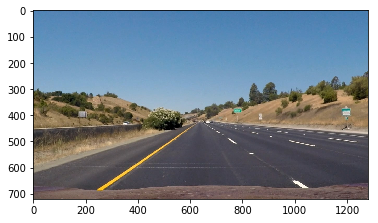

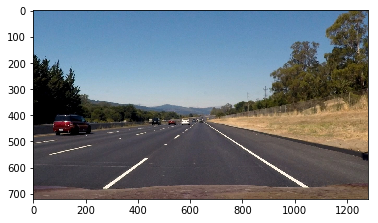

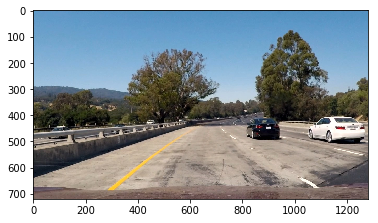

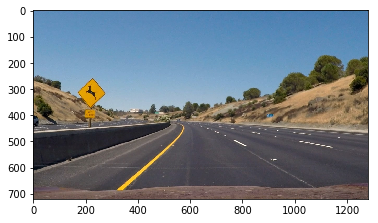

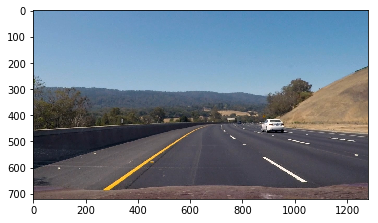

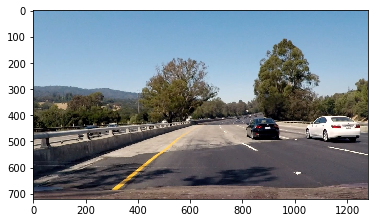

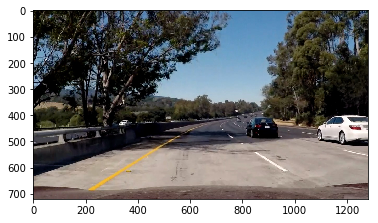

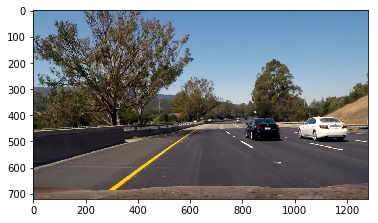

In [27]:
#reading in an image

lane_images = glob.glob('test_images/*.jpg')

k = 0
for fname in lane_images:
    image = mpimg.imread(fname)
    plt.figure(k)
    plt.imshow(image)
    k = k+1
    


### Camera Calibration

In [49]:
import glob

def calibrate():


    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)    
    
    drawPic = False        
    
    calib_images = glob.glob('camera_cal/calibration*.jpg')

    for fname in calib_images:
        
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        if ret == True:

            imgpoints.append(corners)
            objpoints.append(objp)

            if drawPic == True:
                #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                #plt.figure(10)
                #plt.imshow(img)

                plt.figure(10, figsize=(12,9))
                plt.imshow(gray,cmap='gray')
                for k in range(0,len(corners)):
                    x = corners[k][0][0]
                    y = corners[k][0][1]           
                    plt.plot(x,y,'ro')

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        img_size = gray.shape
        dst = np.float32([[0,0],[img_size[1],0],[img_size[1],img_size[0]],[0,img_size[0]]])
    
    print(img_size)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    drawPic = True    
    if drawPic == True:
        
        img = mpimg.imread('camera_cal/test/calibration1.jpg')
        
        undist = cv2.undistort(img, mtx, dist, None, mtx)

        plt.figure(11)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=40)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return mtx, dist


(720, 1280)


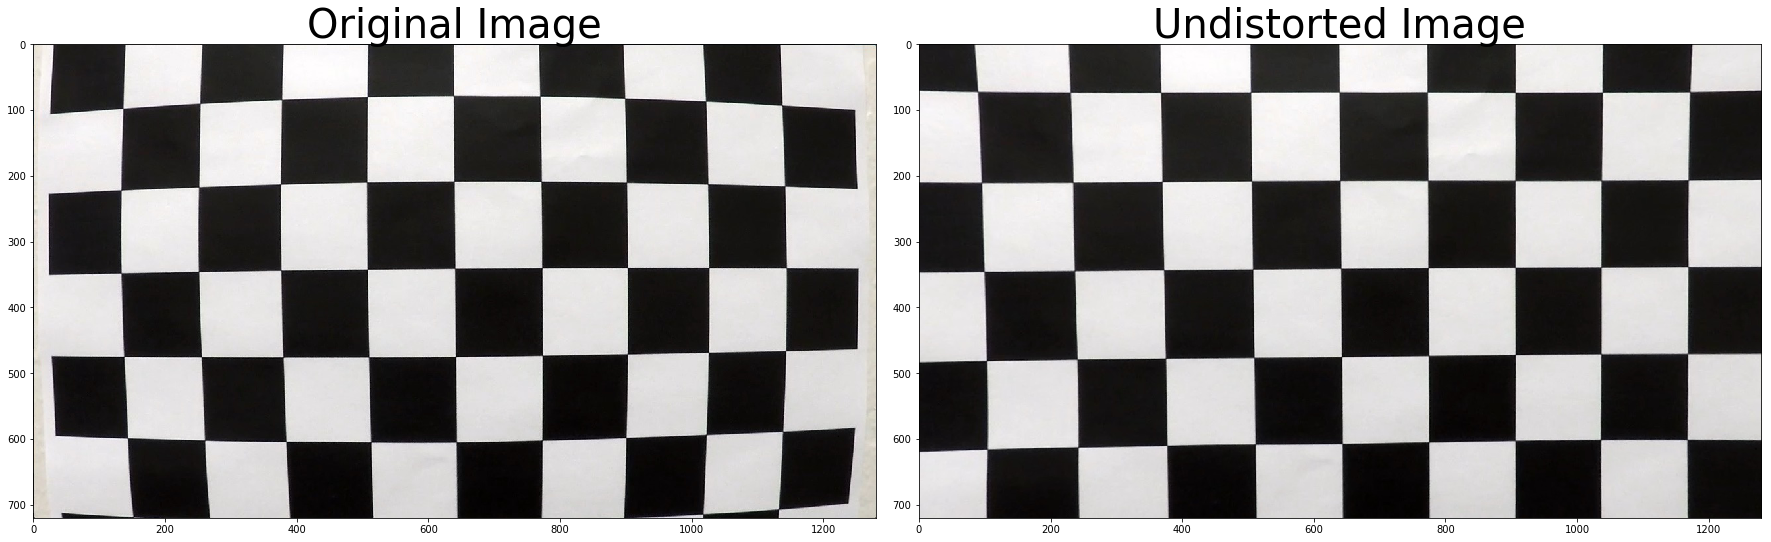

In [50]:
mtx, dist = calibrate()
         

### Undistorted Lane Image

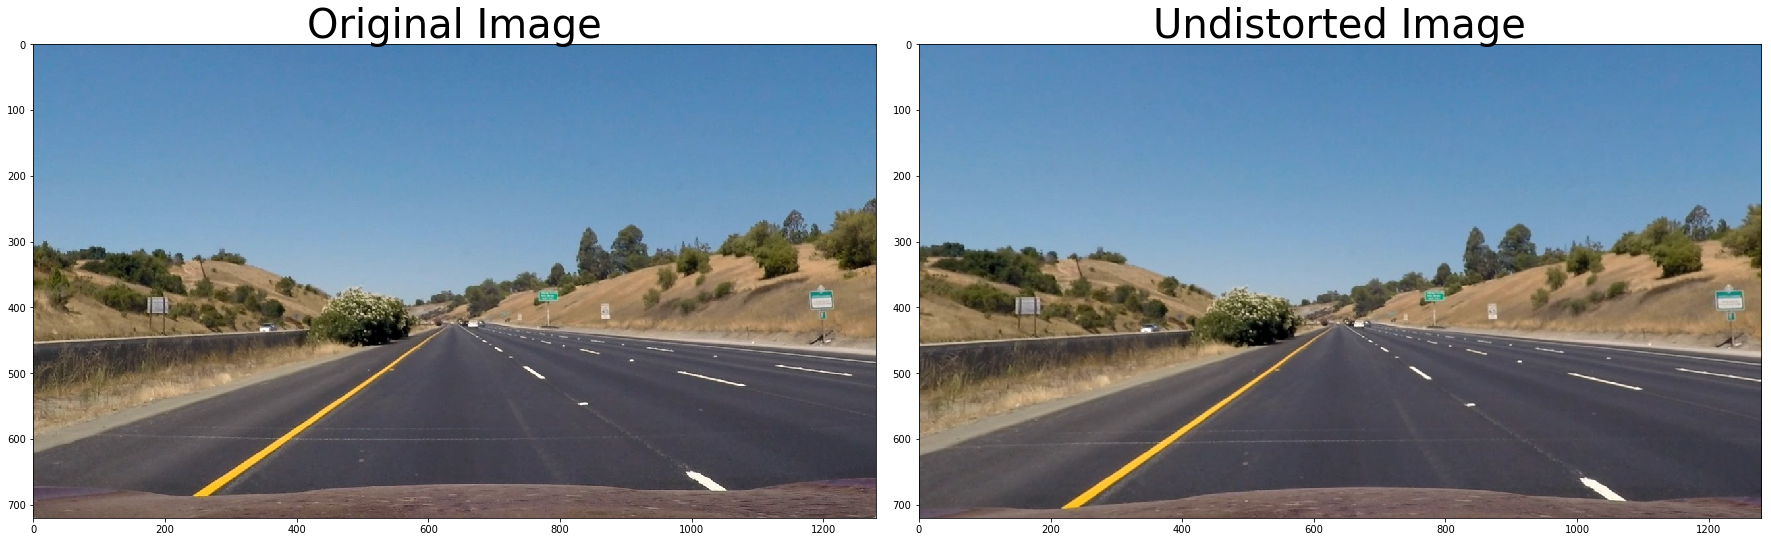

In [51]:
image_dist = mpimg.imread('test_images/straight_lines1.jpg')
image_undist = cv2.undistort(image_dist, mtx, dist, None, mtx)

plt.figure(11)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(image_dist)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 


### Perspective Transform

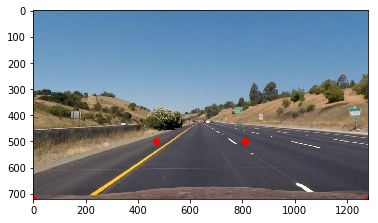

In [90]:
p1 = [0, 719]
p2 = [470, 500]
p3 = [810, 500]
p4 = [1279,719]

plt.imshow(image_undist)
plt.plot(p1[0],p1[1],'ro')
plt.plot(p2[0],p2[1],'ro')
plt.plot(p3[0],p3[1],'ro')
plt.plot(p4[0],p4[1],'ro')

q1 = [0, 719]
q2 = [0, 480]
q3 = [1279, 480]
q4 = [1279, 719]

src = np.float32([p1, p2, p3, p4])
dst = np.float32([q1, q2, q3, q4])

M = cv2.getPerspectiveTransform(src, dst)


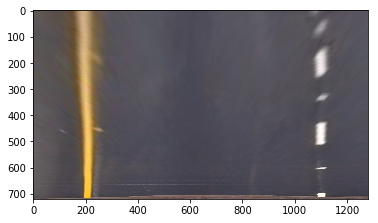

In [92]:
image_warped = cv2.warpPerspective(image_undist, M, (1280,720), flags=cv2.INTER_LINEAR)

plt.imshow(warped)

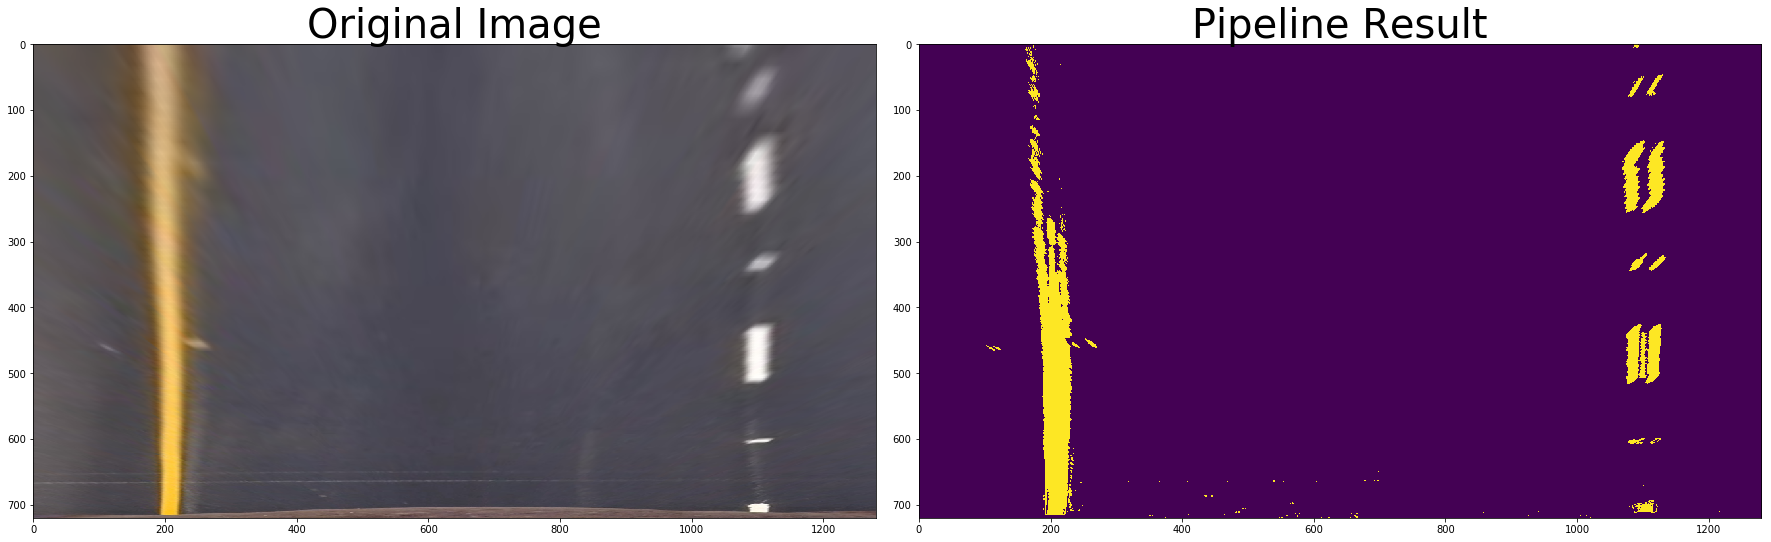

In [94]:
# Edit this function to create your own pipeline.

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
    return combined_binary
    
s_thresh = (170, 255)
sx_thresh = (20, 100)    
image_binary = pipeline(image_warped, s_thresh, sx_thresh)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(image_binary)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

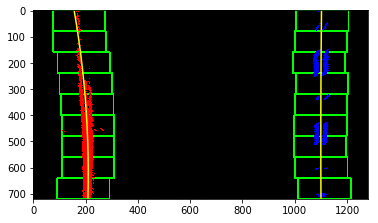

In [95]:
# Read in an image and grayscale it
binary_warped = image_binary

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50    
    # Set window half width
    del_x = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #plt.imshow(out_img)
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - del_x  # Update this
        win_xleft_high = leftx_current + del_x  # Update this
        win_xright_low = rightx_current - del_x  # Update this
        win_xright_high = rightx_current + del_x  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        out2 = cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        plt.imshow(out_img)
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #print(left_lane_inds)
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(binary_warped)
